# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    #plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    #plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

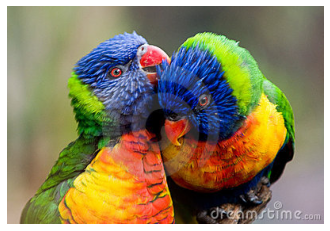

In [3]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [4]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [5]:
height = 275
width = 400
channels = 3

In [6]:
birds = img.reshape(-1, 3)
print(birds.shape)

(110000, 3)


In [32]:
def get_picture(data, classes): # получить по меткам картинку, где каждый пиксель - усредненный по классу
    data = data.copy() # deep copy чтобы не поменять исходную картинку
    for c in (set(classes)):
        mask = classes == c
        if (np.sum(mask) == 0):
            print('oops')
        color = np.mean(data[mask], axis=0)
        data[mask] = color
    return data.reshape(height, width, channels)

In [8]:
ks = [2, 3, 10 ,20]

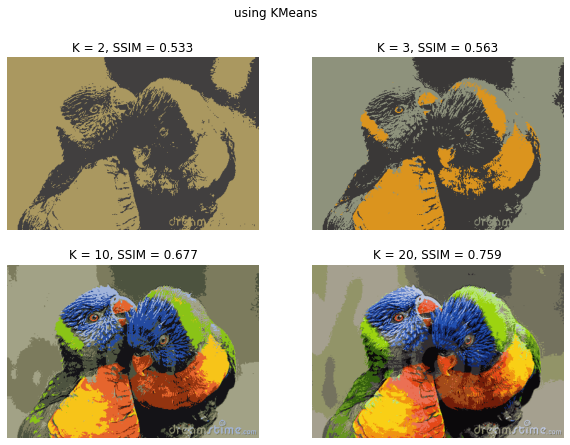

In [9]:
plt.figure(figsize = (10, 7))
plt.suptitle('using KMeans')
for i, k in enumerate(ks):
    plt.subplot(2, 2, i + 1)
    model = KMeans(n_clusters=k)
    classes = model.fit_predict(birds)
    pict = get_picture(birds, classes)
    draw_picture(pict)
    plt.title(f'K = {k}, SSIM = {ssim(pict, img, multichannel=True):.3f}')

In [10]:
print(birds.shape)

(110000, 3)


In [11]:
try:
    for i, k in enumerate(ks):
        model = AgglomerativeClustering(n_clusters=k)
        classes = model.fit_predict(birds.astype(np.float32))
        print('ok')
        pict = get_picture(birds, classes)
        draw_picture(pict)
        plt.title(f'SSIM = {ssim(pict, img, multichannel=True):.3f}');
except:
    print('ERROR')
    

ERROR


### Мы не можем использовать AgglomerativeClustering потому что по определению он использует $O(n^2)$ памяти и $O(n^3)$ времени

### Попробуем DBSCAN

In [17]:
# подберем оптимальные параметры для алгоритма DBSCAN
history = {}
for i in tqdm(range(3, 9)):
    for eps in np.linspace(0.1, 8, 5):
        try:
            model = DBSCAN(eps=eps,  min_samples=i)
            classes = model.fit_predict(birds)
            new_img = get_picture(birds, classes)
            history[(i, eps, len(set(classes)))] = ssim(img, new_img, multichannel=True)
        except:
            continue

100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.79s/it]


In [23]:
item = max(history.items(), key = lambda x : x[1])
print('n, eps, num_classes, ssim:')
print(*item[0], item[1])

n, eps, num_classes, ssim:
3 2.075 2921 0.5165738014218979


Text(0.5, 1.0, 'K = 2921, SSIM = 0.5165738014218979')

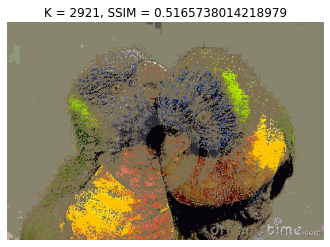

In [26]:
model = DBSCAN(eps=2.075, min_samples=3)
y_pred = model.fit_predict(birds)
new_img = get_picture(birds, y_pred)
draw_picture(new_img)
plt.title(f'K = {len(set(y_pred))}, SSIM = {ssim(img, new_img, multichannel=True)}',)

###  DBSCAN обучается намного хуже

### Мой пример:

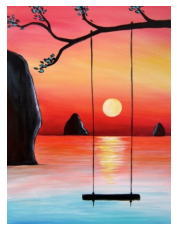

In [41]:
img = cv2.imread('sunset.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [44]:
print(img.shape)

(450, 338, 3)


In [45]:
pic_flat = img.reshape(-1, 3)

In [46]:
height = 450
width = 338
channels = 3

6it [00:30,  5.15s/it]


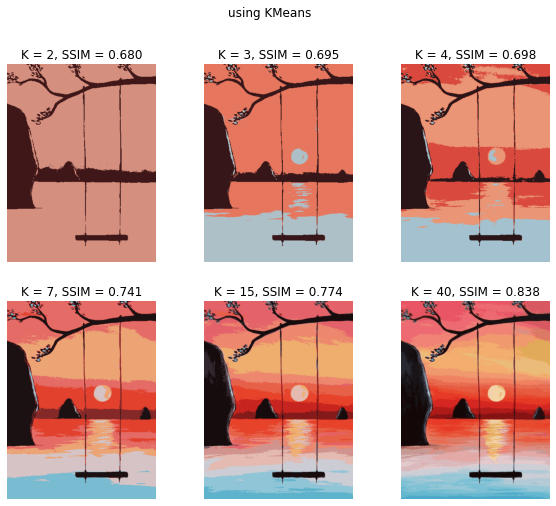

In [51]:
plt.figure(figsize = (10, 8))
plt.suptitle('using KMeans')
for i, k in tqdm(enumerate([2, 3, 4, 7, 15, 40])):
    plt.subplot(2, 3, i + 1)
    model = KMeans(n_clusters=k)
    classes = model.fit_predict(pic_flat)
    pict = get_picture(pic_flat, classes)
    draw_picture(pict)
    plt.title(f'K = {k}, SSIM = {ssim(pict, img, multichannel=True):.3f}')

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [ ]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [ ]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

In [ ]:
y.shape

In [ ]:
names[8] # в y лежат номера, а names переводит номер в имя

In [ ]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц